In [ ]:
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split

n_x = 500000
# Determine p
p = np.logspace(-4, -3, (n_x * 9) // 10)
p = np.concat([p, np.logspace(-6, -5, n_x - len(p))])

# Set covariates x
input_size = 10
x = np.stack([stats.geom.ppf(tau, p)**0.25 for tau in np.linspace(0.1, 0.9, input_size)], axis=1)
x /= x.mean()
x += np.random.normal(0, 0.1, x.shape)
n_x, input_size = x.shape

# Instead of a fixed n_samples, sample a random number of samples for each observation.
# For instance, drawing from a Uniform distribution between 1 and 20000
l, u = 1, 1e3
n_samples_random = np.random.randint(l, u, n_x)

# Generate y for each observation using a list comprehension.
# Each element in y will be an array of Bernoulli trials with its own sample size.
y = [np.random.binomial(1, prob, n) for prob, n in zip(p, n_samples_random)]

# Sum the outcomes for each observation.
b = np.array([yi.sum() for yi in y])

# For example, if you want to compute the "first success" (t_tilde) for each observation:
# Note: since each array in y may have a different length, you need to loop through them.
t_tilde = np.array([np.argmax(yi) + 1 if yi.any() else len(yi) for yi in y])

# And you can construct an event indicator (e) similarly:
# Here, e indicates whether a success occurred.
e = np.array([1 if yi.any() else 0 for yi in y])

print("Example of first 10 p values:", p[:10])
print("Example of corresponding empirical probabilities:", b[:10] / n_samples_random[:10])

# Make a train-test split
p_train, p_test, x_train, x_test, y_train, y_test, t_tilde_train, t_tilde_test, e_train, e_test, b_train, b_test, n_samples_random_train, n_samples_random_test = train_test_split(
    p, x, y, t_tilde, e, b, n_samples_random, test_size=0.2, random_state=42)

# Split a calibration set from the training set
p_train, p_cal, x_train, x_cal, y_train, y_cal, t_tilde_train, t_tilde_cal, e_train, e_cal, b_train, b_cal, n_samples_random_train, n_samples_random_cal = train_test_split(
    p_train, x_train, y_train, t_tilde_train, e_train, b_train, n_samples_random_train, test_size=0.25, random_state=42)

sort_idx = np.argsort(p_test)
p_test = p_test[sort_idx]

Example of first 10 p values: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
Example of corresponding empirical probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.loss import survival_loss, prop_loss

def L1_loss(pred, target):
    return (torch.sigmoid(pred[:,1]) - target).abs().mean()

def L2_loss(pred, target):
    return (torch.sigmoid(pred[:,1]) - target).pow(2).mean()

# Define the model
class Model(nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()
        hidden_dims = [input_size] + hidden_dims + [1]
        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(hidden_dims[:-1], hidden_dims[1:])):
            self.layers.append(nn.Linear(in_dim, out_dim))
            if i < len(hidden_dims) - 2:
                self.layers.append(nn.ReLU())
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the optimizer
def get_optimizer(model, args):
    return optim.AdamW(model.parameters(), **args)

# Define a training function that gets a loss function and model+optimizer parameters, an array of covariates x, and either (t_tilde, e) or b
def train(loss_fn, model_params, optimizer_params, x_train, y_train, gt_p_train, x_val=None, y_val=None, gt_p_val=None, n_epochs=100):
    model = Model(**model_params)
    optimizer = get_optimizer(model, optimizer_params)
    
    # Dataset + DataLoader
    dataset_train = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float).T, torch.tensor(gt_p_train, dtype=torch.float32))
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=100, shuffle=True)

    # Validation
    if x_val is not None:
        dataset_val = torch.utils.data.TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float).T, torch.tensor(gt_p_val, dtype=torch.float32))
        dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=100, shuffle=False)

    def validate():
        epoch_loss = 0
        epoch_gt_ce = 0
        epoch_L1_dist_train = 0
        for batch in dataloader_val:
            x_batch = batch[0]
            y_batch = batch[1].T
            p_batch = batch[2]
            out = model(x_batch)
            loss = loss_fn(torch.concat([1-out, out], dim=1), y_batch)
            gt_ce = torch.nn.functional.binary_cross_entropy_with_logits(out.reshape(-1), p_batch)
            L1 = (torch.sigmoid(out.reshape(-1)) - p_batch).abs().mean()
            epoch_loss += loss.item()
            epoch_gt_ce += gt_ce.item()
            epoch_L1_dist_train += L1.item()
        return epoch_loss / len(dataloader_val), epoch_gt_ce / len(dataloader_val), epoch_L1_dist_train / len(dataloader_val)

    # Training loop
    for epoch in range(n_epochs):
        epoch_loss_train = 0
        epoch_gt_ce_train = 0
        epoch_L1_dist_train = 0
        for batch in dataloader_train:
            x_batch = batch[0]
            y_batch = batch[1].T
            p_batch = batch[2]
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_fn(torch.concat([1-out, out], dim=1), y_batch)
            with torch.no_grad():
                gt_ce = torch.nn.functional.binary_cross_entropy_with_logits(out.reshape(-1), p_batch)
                L1 = (torch.sigmoid(out.reshape(-1)) - p_batch).abs().mean()
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            epoch_gt_ce_train += gt_ce.item()
            epoch_L1_dist_train += L1.item()
        if x_val is not None:
            if epoch % 50 == 0:
                with torch.no_grad():
                    epoch_loss_val, epoch_gt_ce_val, epoch_L1_dist_val = validate()
                print(f"Epoch {epoch} - Train Loss: {epoch_loss_train / len(dataloader_train)} - GT CE: {epoch_gt_ce_train / len(dataloader_train)} - GT L1: {epoch_L1_dist_train / len(dataloader_train)} - Val Loss: {epoch_loss_val} - Val GT CE: {epoch_gt_ce_val} - Val GT L1: {epoch_L1_dist_val}")
        else:
            if epoch % 50 == 49:
                print(f"Epoch {epoch} - Train Loss: {epoch_loss_train / len(dataloader_train)} - GT CE: {epoch_gt_ce_train / len(dataloader_train)} - GT L1: {epoch_L1_dist_train / len(dataloader_train)}")
    return model

# Train the models
# L1_model = train(L1_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, b_train/n_samples_random_train, p_train, x_val=x_test, y_val=b_test/n_samples_random_test, gt_p_val=p_test)
# L2_model = train(L2_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, b_train/n_samples_random_train, p_train, x_val=x_test, y_val=b_test/n_samples_random_test, gt_p_val=p_test)
prop_model = train(prop_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, (b_train/n_samples_random_train, torch.ones(b_train.shape)), p_train, n_epochs=10)#, x_val=x_test, y_val=(b_test/n_samples_random_test, torch.ones(b_test.shape)), gt_p_val=p_test)
survival_model = train(survival_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, (t_tilde_train / t_tilde_train.mean(), e_train / t_tilde_train.mean()), p_train, n_epochs=10)#, x_val=x_test, y_val=(t_tilde_test / t_tilde_train.mean(), e_test / t_tilde_train.mean()), gt_p_val=p_test)

# The losses are based off binary_cross_entropy_with_logits, so we need to apply the sigmoid function to the output
def predict(model, input):
    return torch.sigmoid(model(torch.tensor(input, dtype=torch.float32))).detach().numpy()

# To get valid quantiles we can't have p=0, so we clip it to 1e-30
def clip_p(p):
    return np.maximum(1e-30, p)

# Predict the survival and proportional models
surv_pred = predict(survival_model, x_test)
prop_pred = predict(prop_model, x_test)
# L1_pred = predict(L1_model, x_test)
# L2_pred = predict(L2_model, x_test)

# Sort the p_test values and the predictions
surv_pred = surv_pred[sort_idx]
prop_pred = prop_pred[sort_idx]
# L1_pred = L1_pred[sort_idx]
# L2_pred = L2_pred[sort_idx]

Mean e: 0.149192
Mean p: 0.0003521697168288154
Mean t_tilde: 447.727388
Mean b: 0.17671
Mean n_samples_random: 499.275928
Mean survival model prediction: 0.0003023447
Mean proportional model prediction: 0.00036079614


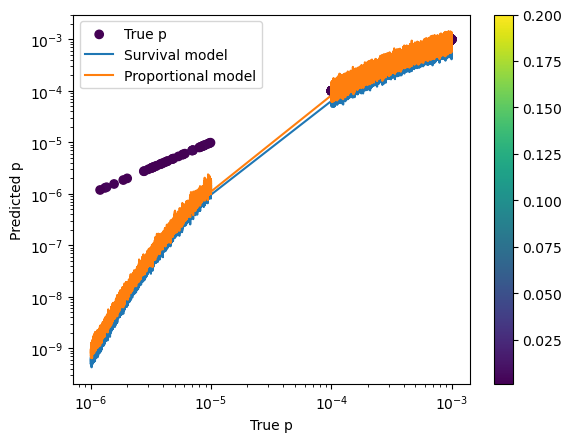

In [259]:
from matplotlib import pyplot as plt

# Print the data features - mean e, mean p, mean t_tilde, mean b, mean n_samples_random
print("Mean e:", e.mean())
print("Mean p:", p.mean())
print("Mean t_tilde:", t_tilde.mean())
print("Mean b:", b.mean())
print("Mean n_samples_random:", n_samples_random.mean())

# Print the mean predicted values
print("Mean survival model prediction:", surv_pred.mean())
print("Mean proportional model prediction:", prop_pred.mean())
# print("Mean L1 model prediction:", L1_pred.mean())
# print("Mean L2 model prediction:", L2_pred.mean())

# Plot the results
plt.figure()
plt.yscale("log")
plt.xscale("log")
empirical_pct_test = (b_test / n_samples_random_test)[sort_idx]
empirical_pct_train = (b_train / n_samples_random_train)
emp_p_train_non_zero = empirical_pct_train > 0
plt.scatter(p_train[emp_p_train_non_zero], p_train[emp_p_train_non_zero], label="True p", c=empirical_pct_train[emp_p_train_non_zero], cmap="viridis")
plt.plot(p_test, surv_pred, label="Survival model")
plt.plot(p_test, prop_pred, label="Proportional model")
# plt.plot(p_test, L1_pred, label="L1 model")
# plt.plot(p_test, L2_pred, label="L2 model")
plt.xlabel("True p")
plt.ylabel("Predicted p")
plt.legend()

# Add a colorbar
plt.colorbar()
plt.show()

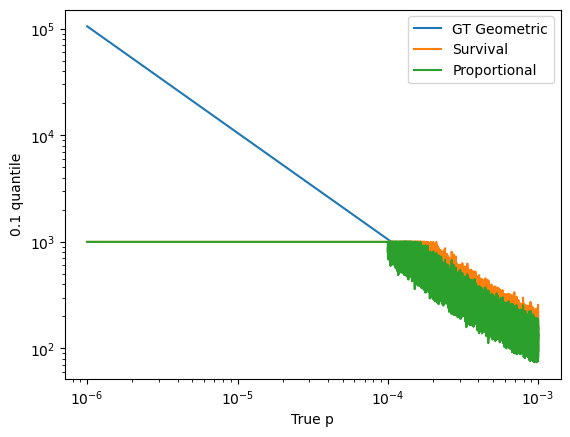

In [270]:
def clip_quantiles(quantiles):
    return np.minimum(quantiles, u-((u-l)/1e3))


# Plot the results in terms of the 0.1 quantile of the Geometric distribution
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.plot(p_test, stats.geom.ppf(0.1, p=p_test), label="GT Geometric")
# plt.plot(p_test, stats.geom.ppf(0.1, p=empirical_pct_test), label="Empiric Geometric")
plt.plot(p_test, clip_quantiles(stats.geom.ppf(0.1, p=clip_p(surv_pred.flatten()))), label="Survival")
plt.plot(p_test, clip_quantiles(stats.geom.ppf(0.1, p=clip_p(prop_pred.flatten()))), label="Proportional") 
# plt.plot(p_test, stats.geom.ppf(0.1, p=clip_p(L1_pred.flatten())), label="L1")
# plt.plot(p_test, stats.geom.ppf(0.1, p=clip_p(L2_pred.flatten())), label="L2")
plt.xlabel("True p")
plt.ylabel("0.1 quantile")
plt.legend()

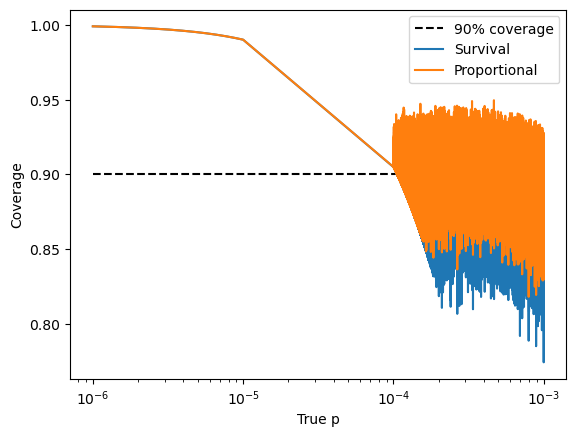

In [271]:
# Plot the coverage of the the predicted 0.1 quantile
plt.figure()
plt.xscale("log")
plt.hlines(0.9, p_test.min(), p_test.max(), label="90% coverage", color="black", linestyle="--")
plt.plot(p_test, 1-stats.geom.cdf(clip_quantiles(stats.geom.ppf(0.1, p=clip_p(surv_pred.flatten()), loc=-1)), p=p_test), label="Survival")
plt.plot(p_test, 1-stats.geom.cdf(clip_quantiles(stats.geom.ppf(0.1, p=clip_p(prop_pred.flatten()), loc=-1)), p=p_test), label="Proportional")
# plt.plot(p_test, 1-stats.geom.cdf(stats.geom.ppf(0.1, p=clip_p(L1_pred.flatten()), loc=-1), p=p_test), label="L1")
# plt.plot(p_test, 1-stats.geom.cdf(stats.geom.ppf(0.1, p=clip_p(L2_pred.flatten()), loc=-1), p=p_test), label="L2")
plt.xlabel("True p")
plt.ylabel("Coverage")
plt.legend()

/tmp/ipykernel_3479197/3973906765.py:25: RuntimeWarning: invalid value encountered in divide
  tau_hats = (weights * T_tilde_miscoverage).sum(axis=0) / weights.sum(axis=0)


Chose the [235]-th canidate
Chose the [240]-th canidate
Conformalized survival quantile: 0.08506793416364153
Conformalized proportional quantile: 0.10312831606721848


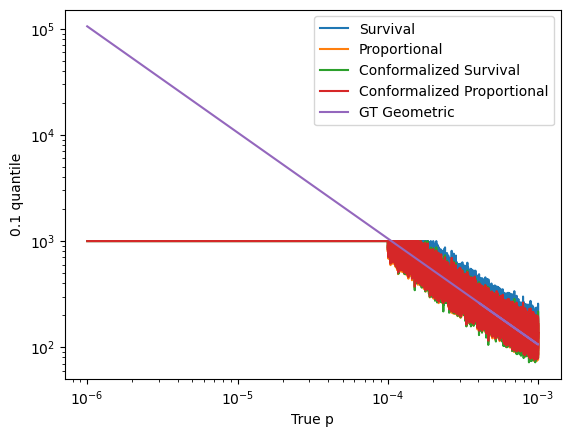

In [278]:
# Create for each model a family of quantile estimators
from regex import T


def quantile_estimators(preds, taus):
    return np.array([stats.geom.ppf(q, p=clip_p(preds.flatten())) for q in taus])

# Create an estimator for P[q_\tau(X) <= C | X], where C is a discrete uniform random variable between l and u
def conditional_probability(quantile_est, l, u):
    return np.clip((u - quantile_est) / (u - l), 0, 1)

# Define the conformalizing function
def conformalize(preds, target_taus, canidate_taus, C, T_tilde):
    # Compute the quantile estimators
    quantile_est = clip_quantiles(quantile_estimators(preds, canidate_taus))

    # Compute the weights - 1/conditional_probability
    # Print all the shapes
    weights = 1./conditional_probability(quantile_est, l, u)
    weights = np.where(quantile_est <= C, weights, 0).T

    T_tilde_miscoverage = np.where(T_tilde < quantile_est, 1, 0).T

    # Compute the estimated miscoverage for each quantile
    tau_hats = (weights * T_tilde_miscoverage).sum(axis=0) / weights.sum(axis=0)

    # # Fill in the missing values
    # tau_hats = np.where(np.isnan(tau_hats), 1, tau_hats)
    
    tau_diff = target_taus - tau_hats[:, np.newaxis]
    smallest_pos = np.where(tau_diff > 0, 1, -1. * np.inf).cumsum(axis=0).argmax(axis=0)
    print(f"Chose the {smallest_pos}-th canidate")
    a_hats = canidate_taus[smallest_pos]

    return a_hats, weights, T_tilde_miscoverage

# Define the target quantiles
target_taus = np.array([0.1])

# Define the candidate quantiles
candidate_taus = np.logspace(-5, 0, 300)

# Predict the p for the calibration set
surv_pred_cal = predict(survival_model, x_cal)
prop_pred_cal = predict(prop_model, x_cal)

# Conformalize the predictions
conformalized_surv, weights_surv, T_tilde_miscoverage_surv = conformalize(surv_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal)
conformalized_prop, weights_prop, T_tilde_miscoverage_prop = conformalize(prop_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal)

conformalized_surv = conformalized_surv[0]
conformalized_prop = conformalized_prop[0]

print(f"Conformalized survival quantile: {conformalized_surv}")
print(f"Conformalized proportional quantile: {conformalized_prop}")

# Plot the conformalized quantiles
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.plot(p_test, clip_quantiles(stats.geom.ppf(0.1, p=clip_p(surv_pred.flatten()))), label="Survival")
plt.plot(p_test, clip_quantiles(stats.geom.ppf(0.1, p=clip_p(prop_pred.flatten()))), label="Proportional")
plt.plot(p_test, clip_quantiles(stats.geom.ppf(conformalized_surv, p=clip_p(surv_pred.flatten()))), label="Conformalized Survival")
plt.plot(p_test, clip_quantiles(stats.geom.ppf(conformalized_prop, p=clip_p(prop_pred.flatten()))), label="Conformalized Proportional")
plt.plot(p_test, stats.geom.ppf(0.1, p=p_test), label="GT Geometric")
plt.xlabel("True p")
plt.ylabel("0.1 quantile")
plt.legend()

In [279]:
# Print mean coverage and mean quantile value for each model
print("Survival model mean coverage:", (1-stats.geom.cdf(clip_quantiles(stats.geom.ppf(0.1, p=clip_p(surv_pred.flatten()), loc=-1)), p=p_test)).mean())
print("Survival model mean quantile:", clip_quantiles(stats.geom.ppf(0.1, p=clip_p(surv_pred.flatten()), loc=-1)).mean())
print("Proportional model mean coverage:", (1-stats.geom.cdf(clip_quantiles(stats.geom.ppf(0.1, p=clip_p(prop_pred.flatten()), loc=-1)), p=p_test)).mean())
print("Proportional model mean quantile:", clip_quantiles(stats.geom.ppf(0.1, p=clip_p(prop_pred.flatten()), loc=-1)).mean())
print("Conformalized survival model mean coverage:", (1-stats.geom.cdf(clip_quantiles(stats.geom.ppf(conformalized_surv, p=clip_p(surv_pred.flatten()), loc=-1)), p=p_test)).mean())
print("Conformalized survival model mean quantile:", clip_quantiles(stats.geom.ppf(conformalized_surv, p=clip_p(surv_pred.flatten()), loc=-1)).mean())
print("Conformalized proportional model mean coverage:", (1-stats.geom.cdf(clip_quantiles(stats.geom.ppf(conformalized_prop, p=clip_p(prop_pred.flatten()), loc=-1)), p=p_test)).mean())
print("Conformalized proportional model mean quantile:", clip_quantiles(stats.geom.ppf(conformalized_prop, p=clip_p(prop_pred.flatten()), loc=-1)).mean())

Survival model mean coverage: 0.8967047132085758
Survival model mean quantile: 518.3984990600001
Proportional model mean coverage: 0.9119943288387117
Proportional model mean quantile: 456.53640838000007
Conformalized survival model mean coverage: 0.9108008514116134
Conformalized survival model mean quantile: 464.31897893
Conformalized proportional model mean coverage: 0.9093850518894788
Conformalized proportional model mean quantile: 466.94572630000005


In [280]:
largest_selected_weight_idx = (weights_surv * T_tilde_miscoverage_surv)[:, 240].argmax()
weights_surv[largest_selected_weight_idx, 240]
print(n_samples_random_cal[largest_selected_weight_idx])
print(t_tilde_cal[largest_selected_weight_idx])
print(p_cal[largest_selected_weight_idx])
# print the smallest p_cal for which (weights_surv * T_tilde_miscoverage_surv)[:, 240] != 0
print(p_cal[(weights_surv * T_tilde_miscoverage_surv)[:, 240] != 0].min())
# print the smallest p_cal for which T_tiilde_miscoverage_surv[:, 240] != 0
print(p_cal[T_tilde_miscoverage_surv[:, 240] != 0].min())
# print the smallest p_cal for which weights_surv[:, 240] != 0
print(p_cal[weights_surv[:, 240] != 0].min())

975
127
0.00014664642518465125
0.00011409154481131347
1.0000921094876437e-06
0.00010396648732304242
